## Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils

In [4]:
# set constants and hyperparameters

DATASET = 'data/2023_quy1.csv'
# Minimum value: 20.5
# Maximum value: 32.5
# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [5]:
# import time series

x = pd.read_csv(DATASET)

# x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S", dayfirst=True)
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

temp = x['temperature']
# temp = temp[temp>=18]
# temp = temp.resample('H').mean()

train = temp[(temp.index.year>=2022)]
# test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

Number of time stamps: 10811
First 3 time stamps: 2023-01-01 00:17:01, 2023-01-01 00:19:03, 2023-01-01 00:41:58
Last 3 time stamps: 2023-03-27 20:50:42, 2023-03-27 21:14:50, 2023-03-27 21:25:27


time
2023-01-01 00:17:01    22.1
2023-01-01 00:19:03    22.9
2023-01-01 00:41:58    22.9
2023-01-01 00:43:16    21.9
2023-01-01 01:04:53    22.9
Name: temperature, dtype: float64

## Prepare Training Data


In [6]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.new_apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

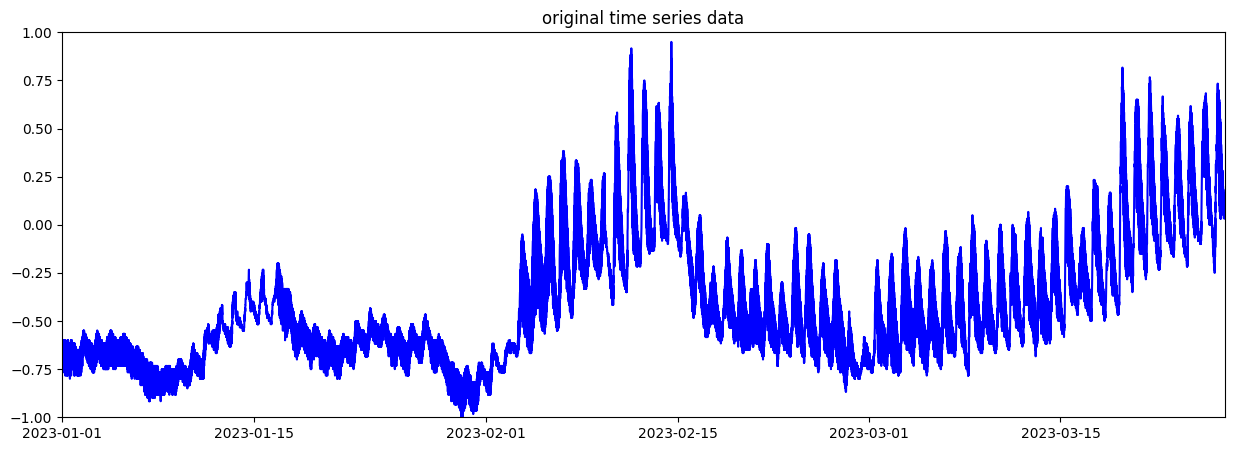

In [8]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series data')

In [9]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 10712
Start times of the first 3 windows: ['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000']


## Train Reconstruction Model (TadGAN)

In [10]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [11]:
# train the model

t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
t1 = time.time()

model.save_model("./model/model_tran_100_quy1_3m")

Epoch 1/100 (121.7 secs)
  Critic X Loss: -0.276256 [-3.04173384  0.77301281  0.19924655]
  Critic Z Loss: 5.514075 [-0.29893012  3.83395541  0.19790498]
  Encoder Generator Loss: -1.878510 [-0.68501574 -3.12859236  0.19350983]
Epoch 2/100 (88.4 secs)
  Critic X Loss: -1.226744 [ 0.61869558 -2.21656039  0.03711205]
  Critic Z Loss: -14.865764 [ -0.24338786 -16.80518524   0.21828092]
  Encoder Generator Loss: 22.457401 [ 2.3915838  17.99143083  0.20743865]
Epoch 3/100 (92.4 secs)
  Critic X Loss: -1.683261 [-5.39100159  3.48876113  0.02189796]
  Critic Z Loss: -0.167759 [ 0.08270455 -1.38726434  0.11368003]
  Encoder Generator Loss: -1.141339 [-3.42680386  1.4159918   0.08694729]
Epoch 4/100 (87.0 secs)
  Critic X Loss: -1.072768 [ 0.91487911 -2.19770776  0.02100606]
  Critic Z Loss: 0.630027 [ 0.26918403 -0.82819096  0.11890341]
  Encoder Generator Loss: 4.285843 [2.37423279 0.99857448 0.09130362]
Epoch 5/100 (94.9 secs)
  Critic X Loss: -0.897539 [-4.61051761  3.47216522  0.02408132]


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_encoder\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_encoder\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_generator\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_generator\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_critic_x\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_critic_x\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_critic_z\assets


INFO:tensorflow:Assets written to: ./model/model_tran_100_quy1_3m_critic_z\assets


In [8]:
model.get_model("./model/model_tran_100_quy1_3m")

In [12]:
print(f'Total training time for {EPOCHS} epochs: {t1 - t0:.1f} secs')

Total training time for 100 epochs: 8698.7 secs


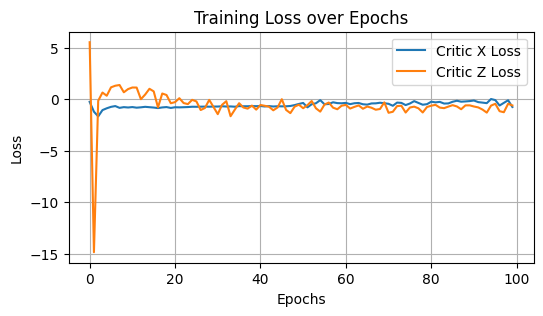

In [14]:
critic_x_loss_history, critic_z_loss_history, encoder_generator_loss_history = model.getLoss()
critic_x_total_loss = [loss[0] for loss in critic_x_loss_history]
critic_z_total_loss = [loss[0] for loss in critic_z_loss_history]
encoder_generator_total_loss = [loss[0] for loss in encoder_generator_loss_history]

plt.figure(figsize=(6, 3))
plt.plot(critic_x_total_loss, label='Critic X Loss')
plt.plot(critic_z_total_loss, label='Critic Z Loss')
# plt.plot(encoder_generator_total_loss, label='Encoder Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

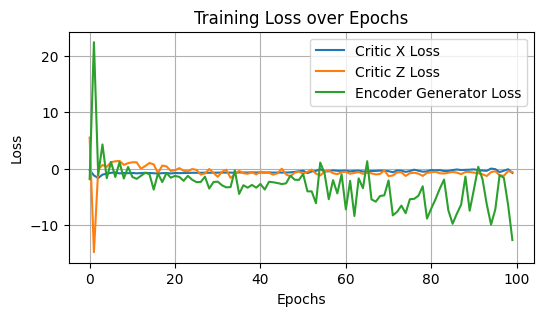

In [16]:
plt.figure(figsize=(6, 3))
plt.plot(critic_x_total_loss, label='Critic X Loss')
plt.plot(critic_z_total_loss, label='Critic Z Loss')
plt.plot(encoder_generator_total_loss, label='Encoder Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(x_win)

[[-0.73333333 -0.6        -0.6        ... -0.75       -0.61666667
  -0.75      ]
 [-0.6        -0.6        -0.76666667 ... -0.61666667 -0.75
  -0.61666667]
 [-0.6        -0.76666667 -0.6        ... -0.75       -0.61666667
  -0.75      ]
 ...
 [-0.01666667  0.01666667 -0.01666667 ...  0.16666667  0.48333333
   0.16666667]
 [ 0.01666667 -0.01666667 -0.01666667 ...  0.48333333  0.16666667
   0.18333333]
 [-0.01666667 -0.01666667  0.01666667 ...  0.16666667  0.18333333
   0.45      ]]


In [17]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)

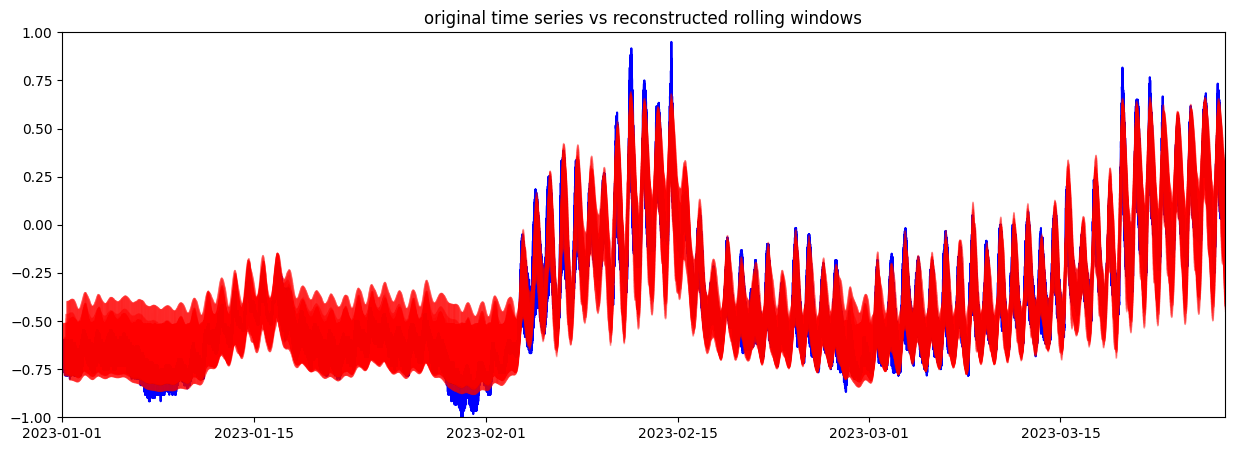

In [18]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

In [19]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

In [26]:
print(t)

['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000' ... '2023-02-28T23:28:35.000000000'
 '2023-02-28T23:48:27.000000000' '2023-02-28T23:48:37.000000000']


In [21]:
print(train)

[-0.73333333 -0.6        -0.6        ...  0.16666667  0.18333333
  0.45      ]


In [20]:
print(detected_intervals)

[['2023-02-06T02:13:53.000000000' '2023-02-06T22:00:51.000000000']
 ['2023-02-11T05:52:35.000000000' '2023-02-12T03:20:12.000000000']
 ['2023-03-27T05:34:06.000000000' '2023-03-27T21:25:27.000000000']]


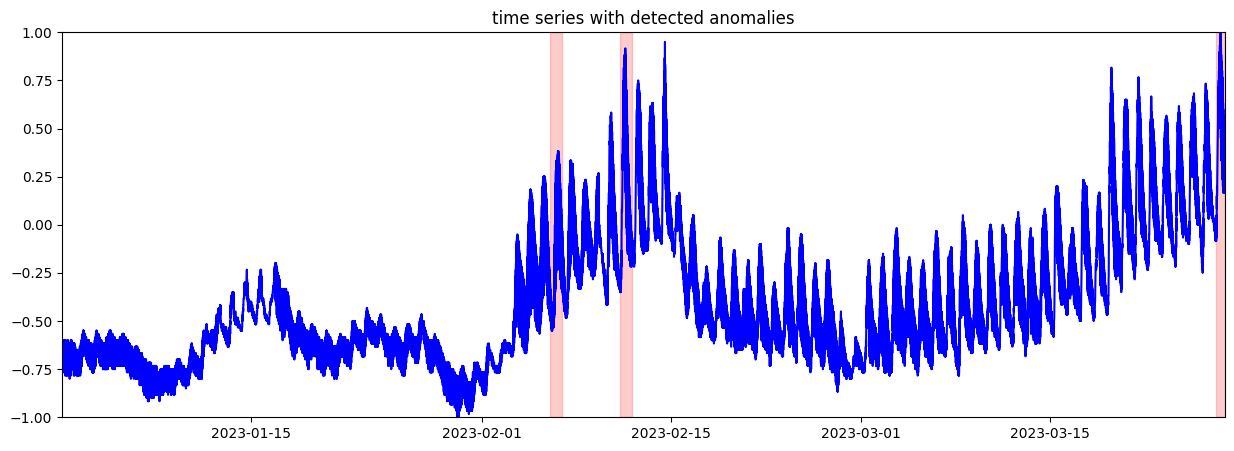

In [21]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')